In [32]:
import numpy as np
import pandas as pd
import gurobipy as gp
from scipy.optimize import minimize
import matplotlib as plt

# Portfolio Optimization

In [4]:
train_raw=pd.read_csv('training_data.csv')
test_raw=pd.read_csv('test_data.csv')

In [5]:
y_train=train_raw['y']
x_train=train_raw.iloc[:,1:]
y_test=test_raw['y']
x_test=test_raw.iloc[:,1:]
# X and y mtrix
X_train=np.ones((train_raw.shape[0],train_raw.shape[1]))
X_train[:,1:]=x_train
X_test=np.ones((x_test.shape[0],train_raw.shape[1]))
X_test[:,1:]=x_test

In [6]:
# m=50 here
m=x_train.shape[1]
n= 250 
n=x_train.shape[0]
M = 1000
k=10

In [7]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.0,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,1.0,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,1.0,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,1.0,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,1.0,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.0,0.210132,-0.193059,2.033908,-0.832887,0.049040,-0.197864,-1.885529,-2.526842,-0.826903,...,0.555085,-2.099135,-0.411719,1.053645,-0.172623,-1.207709,0.748914,-1.343144,-0.696000,0.525172
246,1.0,-0.039047,-0.021366,1.040784,-3.435317,-0.419417,0.293139,-0.165674,-0.357788,-0.943576,...,-0.564113,-1.721975,-0.556074,0.028959,0.594509,-1.010988,-0.205257,-0.148502,-0.656065,0.140523
247,1.0,0.091237,0.473698,0.051832,0.721924,0.337938,1.322324,-0.605442,0.428120,0.003276,...,0.348330,0.099530,0.019925,1.121458,1.901447,-0.431072,-0.124469,-0.084185,-0.200143,0.840786
248,1.0,-1.407003,0.510886,-2.077584,-0.438144,2.225628,0.165129,-1.335051,1.348180,-0.031812,...,-1.076265,1.303594,-1.458794,1.172178,0.451014,0.572106,-3.660368,-0.052251,0.543762,0.274006


In [8]:
# sigma is a 2*m+1 X 2*m+1matrix
sigma=np.zeros((2*m+1,2*m+1))
sigma[:m+1,:m+1]=X_train.T@X_train
#bX_train
linear_term=np.zeros((2*m+1))
linear_term[:m+1]=-2*(y_train.T@X_train)

In [68]:
#initiate constraint matrix
A=np.zeros((2*m+1,2*m+1))
b=np.zeros((A.shape[0]))
sense=['']*A.shape[0]

(101, 101)

In [10]:
A=np.zeros((2*m+1,2*m+1))
b=np.zeros((A.shape[0]))
sense=['']*A.shape[0]

#weights are <>0 when it's 'turned on'
row=0
for i in range(1,m+1,1):
    A[row,[i,i+m]]=[1,-M]
    sense[row]='<'
    b[row]=0
    row+=1
for i in range(1,m+1,1):
    A[row,[i,i+m]]=[1,M]
    sense[row]='>'
    b[row]=0
    row+=1

A[row,m+1:]=1
sense[row]='='
b[row]=k

In [11]:
ub=[M]*(m+1)+[1]*m
lb=[-M]*(m+1)+[0]*m
vtype=['C']*(m+1)+['B']*m

In [12]:
y_train@y_train.T

5322.525934829495

# Solve it as a QP

In [13]:
MIQPMod = gp.Model()
MIQPMod_x = MIQPMod.addMVar((2*m+1),ub=ub,lb=lb,vtype=vtype)
MIQPMod_con = MIQPMod.addMConstrs(A, MIQPMod_x, sense, b)

#no linear so none
#only quadratic matrix sigma

MIQPMod.setMObjective(sigma,linear_term,0,sense=gp.GRB.MINIMIZE)

MIQPMod.Params.OutputFlag = 0 

MIQPMod.optimize()

Academic license - for non-commercial use only - expires 2022-01-03
Using license file C:\Users\Jessi\gurobi.lic


In [14]:
weight_10_s=pd.DataFrame(MIQPMod_x.x[:m+1])


array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

# Cross Validation

In [15]:
# This to build a linear regression model on minimizing square error

def lr(X,y,n=10,timelimit=10):
    # sigma is a 2*(m+1)X2*(m+1)matrix
    
    m=X.shape[1]-1
    sigma=np.zeros((2*m+1,2*m+1))
    sigma[:m+1,:m+1]=X.T@X
   
    linear_term=np.zeros((2*m+1))
    linear_term[:m+1]=-2*(y.T@X)
    
    A=np.zeros((2*m+1,2*m+1))
    b=np.zeros((A.shape[0]))
    sense=['']*A.shape[0]

    #weights are <>0 when it's 'turned on'
    row=0
    for i in range(1,m+1,1):
        A[row,[i,i+m]]=[1,-10]
        sense[row]='<'
        b[row]=0
        row+=1
    for i in range(1,m+1,1):
        A[row,[i,i+m]]=[1,10]
        sense[row]='>'
        b[row]=0
        row+=1

    A[row,m+1:]=1
    sense[row]='='
    b[row]=n
    
    #optimization parameters
    ub=[M]*(m+1)+[1]*m
    lb=[-M]*(m+1)+[0]*m
    vtype=['C']*(m+1)+['B']*m
    
    MIQPMod = gp.Model()
    MIQPMod_x = MIQPMod.addMVar((2*m+1),ub=ub,lb=lb,vtype=vtype)
    MIQPMod_con = MIQPMod.addMConstrs(A, MIQPMod_x, sense, b)

    #no linear so none
    #only quadratic matrix sigma

    MIQPMod.setMObjective(sigma,linear_term,0,sense=gp.GRB.MINIMIZE)
    MIQPMod.Params.OutputFlag = 0 
    
    MIQPMod.Params.TimeLimit = timelimit
    MIQPMod.optimize()
    
    return MIQPMod_x.x[:m+1],MIQPMod.objVal+y@y.T


# This to cross validate the linear regression model
'''
In order to do cross validation on the MIQP model you will have to write your own cross 
validation code. Randomly shuffle your data and split it into 10 folds. You can use the 
‘np.random.choice()’ function in Python to shuffle your data. 

'''
def lr_cv(X,y,n=5,k_fold=10,timelimit=100):
    idx=np.linspace(0,X.shape[0]-1,X.shape[0])
    np.random.shuffle(idx)
    idx=np.split(idx,k_fold)
    err_sum=0
    for i in range(k_fold):
        X_valid=X[idx[i].astype(int)]
        y_valid=y[idx[i].astype(int)]
        rowlist=[]
        for j in range(X.shape[0]):
            if j not in idx[i].astype(int):
                rowlist.append(j)
        X_train=X[rowlist]
        y_train=y[rowlist]
        weight, err=lr(X_train,y_train,n,timelimit)      
        valid_err=np.sum(weight.T@X_valid.T@X_valid@weight-2*y_valid.T@X_valid@weight+y_valid@y_valid.T)
        err_sum+=valid_err
    return weight, err_sum/10

def lr_pred(weight,X):
    return X@weight

In [112]:
'''
There are 50 X variables, 
and you will need to try k = 5, 10, 15, …, 50 in your cross validation. This means to do 
10-fold cross validation with all possible values of k, you will have to solve an MIQP 
model 100 times! Pick the value of k that corresponds to the smallest cross validation 
error: for a given value of k, sum each validation set’s sum of squared errors using the 
s found using the other 9 folds’ data to solve the MIQP. When k is 5 or 50, gurobi 
should solve the problem pretty quickly, but when k is 25 it will probably take a long 
time. Therefore, you should set a time limit for gurobi to solve each problem. Don’t let 
the entire process run for any longer than 12 hours. Again, be smart about setting this 
up, so that you can run it once, save the results, and then import those results when you 
create the final version of your python code and pdf file. Also, set a time limit variable 
at the very beginning of your python code so that we can shorten the runtime of your 
code when we grade it.


It is very important to remember that gurobi assumes all decision variables are 
non-negative. In order to allow your beta s to be negative or positive you must set 
the lb value of your model to be -M for the appropriate decision variables.
b. It is also very important that you choose M to be large enough so that no value 
of beta is equal to M or -M. If you solve the problem and one of your beta s is M or -M 
then you should double M and resolve the problem. Repeat this process until no 
beta is equal to M or -M

M chosen here is 1000 (see the very front of the code)

The following code calls the lv_cv function with variable k values. This chunk of code will take a few hours
to run. Since I have already run it, I saved the result to the weight_matrix_1000_v2.csv file, and it can be
loaded directly without rerun the code.

'''

'''
# cv=10, try limiting to n=5,10,15,20 weights to
weight_update=[]
err_update=[]
for n in np.linspace(5,50,10):
    weight,err=lr_cv(X_train,y_train,n,10,timelimit=1000)
    weight_update.append(weight)
    err_update.append(err)
    
mtx=pd.DataFrame(columns=['weight','err'],index=['k=5','k=10','k=15','k=20','k=25','k=30','k=35','k=40','k=45','k=50'])
mtx['weight']=weight_update
mtx['err']=err_update
mtx.to_csv('weight_matrix_1000_v2.csv',index=0)
'''

<ipython-input-107-ac196cd8f394>:67: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weight, err=lr(X_train,y_train,n,timelimit)


In [16]:
mtx_1000 = pd.read_csv('weight_matrix_1000_v2.csv')

mtx_1000.columns=['weight','err']
mtx_1000.index=['k=5','k=10','k=15','k=20','k=25','k=30','k=35','k=40','k=45','k=50']
weight_10=mtx_1000['weight'][1]


<AxesSubplot:>

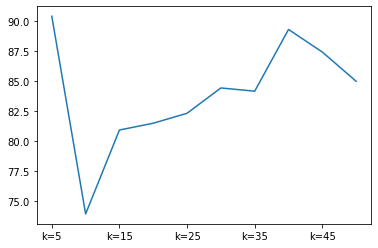

In [17]:
mtx_1000['err'].plot(kind='line')

In [18]:
'''This is the weight matrix given by the homemade Linear Regression model at k=10, where the error is minimized'''
weight_10,err_10 = lr(X_train,y_train,n=10,timelimit=5000)

<ipython-input-18-b92270791a87>:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weight_10,err_10 = lr(X_train,y_train,n=10,timelimit=5000)


In [96]:
'''
temp=weight_10.split()
w=[]
for i in range(1,51,1):
    w.append(float(temp[i]))
    
w    
'''

[0.97194736,
 0.0,
 0.0,
 0.20427237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -2.39940205,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.61044033,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.67181653,
 0.85221611,
 0.0,
 -1.26024675,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.45402298,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.28134298,
 1.85524561,
 0.0,
 0.87758985,
 0.0,
 0.0]

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

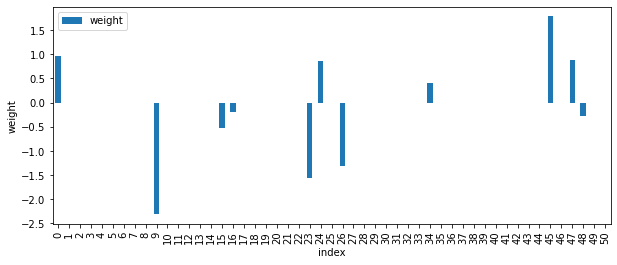

In [70]:
wt_mtx=pd.DataFrame(weight_10)
wt_mtx.columns=['weight']
wt_mtx.plot(kind='bar',figsize=(10,4),xlabel='index',ylabel='weight')
weight_10

# Lasso CV

In [40]:
import numpy as np
from sklearn.metrics import SCORERS
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

In [45]:
'''
Use scikit learn to do 10-fold cross validation on the training set to pick lambda. Once you find 
the best value of lambda, fit a LASSO model to the entire training set using that value of lambda. 
With the beta s you find in that LASSO model make a prediction of the y values in the test set
'''
import warnings
warnings.simplefilter("ignore")

#Grid Search for alpha(or lambda)
alpha_grid = 10**np.linspace(6,-6,100)
tuned_parameters = [{'alpha': alpha_grid}]
lasso = Lasso()
lasso_cv_grid = GridSearchCV(lasso, 
                              tuned_parameters, 
                              cv=10, scoring = 'neg_mean_squared_error', 
                              refit=True) #build lasso model with 10 fold
lasso_cv_grid.fit(X_train,y_train)
lasso_lambda=lasso_cv_grid.best_params_

In [47]:
alpha=list(lasso_lambda.values())[0]

lasso_cv_model=LassoCV(alphas=[alpha],
                     cv=10,)
lasso_cv_model.fit(X_train[:,1:], y_train)
lasso_weight=lasso_cv_model.coef_

In [48]:
lasso_lambda

{'alpha': 0.07054802310718646}

In [49]:
lasso_weight

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16759923,  0.        ,
       -0.06543049, -0.        , -0.        , -0.        , -0.41968302,
       -0.1952272 ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.1939836 , -1.36867927,  0.74620669, -0.00605903,
       -1.30816494, -0.        ,  0.        ,  0.05717854,  0.        ,
       -0.        ,  0.        , -0.09717768,  0.29386359,  0.        ,
        0.        ,  0.        ,  0.        , -0.23972899,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03733622,  1.56934772,
       -0.02949255,  0.71091105, -0.09588212,  0.        ,  0.        ])

<AxesSubplot:xlabel='index', ylabel='weight'>

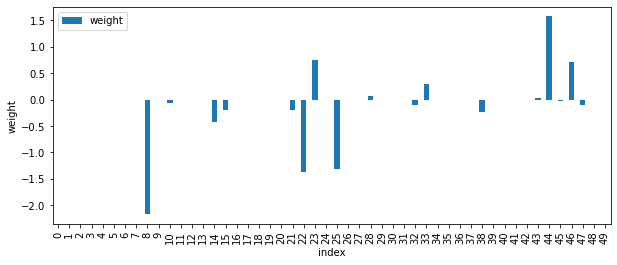

In [50]:
wt_mtx1=pd.DataFrame(lasso_weight)
wt_mtx1.columns=['weight']
wt_mtx1.plot(kind='bar',figsize=(10,4),xlabel='index',ylabel='weight')

In [52]:
y_train_pred_lasso=lasso_cv_model.predict(X_train[:,1:])
y_test_pred_lasso=lasso_cv_model.predict(X_test[:,1:])

In [53]:
mse_train_lasso=np.sum(np.square(np.subtract(y_train_pred_lasso,y_train)))/y_train.shape[0]
mse_test_lasso=np.sum(np.square(np.subtract(y_test_pred_lasso,y_test)))/y_test.shape[0]

In [54]:
y_train_pred_lr=lr_pred(weight_10,X_train)
y_test_pred_lr=lr_pred(weight_10,X_test)
mse_train_lr=np.sum(np.square(np.subtract(y_train_pred_lr,y_train)))/y_train.shape[0]
mse_test_lr=np.sum(np.square(np.subtract(y_test_pred_lr,y_test)))/y_test.shape[0]

In [55]:
err=np.array(([mse_train_lasso,mse_train_lr],[mse_test_lasso,mse_test_lr]))
err

array([[2.35677717, 2.39198527],
       [2.3461395 , 2.33654396]])

In [56]:
err_mtx=pd.DataFrame(err,columns=['lasso err','linear reg err'],
                     index=['train','test'])
err_mtx

,lasso err,linear reg err
train,2.356777,2.391985
test,2.346139,2.336544


<AxesSubplot:xlabel='training sample'>

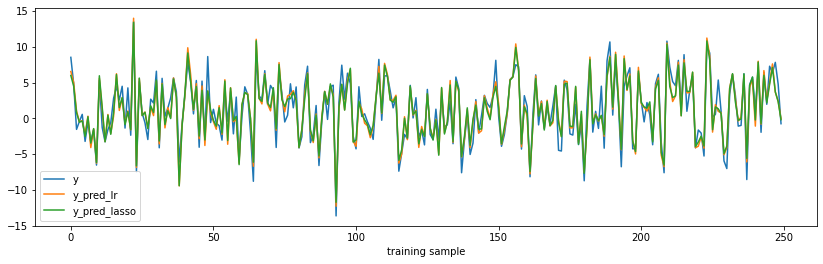

In [66]:
y_train_comp=pd.DataFrame(columns=['y','y_pred_lr','y_pred_lasso'])
y_train_comp['y']=y_train
y_train_comp['y_pred_lr']=y_train_pred_lr
y_train_comp['y_pred_lasso']=y_train_pred_lasso
y_train_comp.plot(kind='line',figsize=(14,4),xlabel='training sample')

<AxesSubplot:xlabel='test sample'>

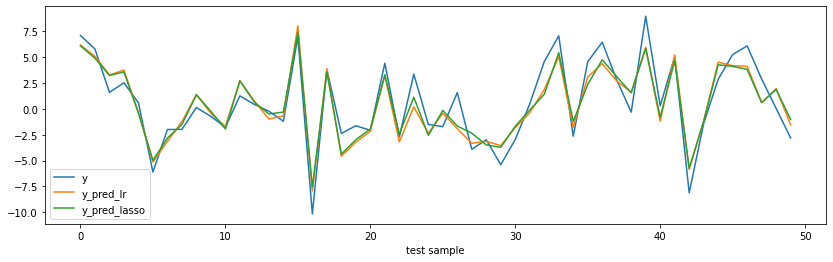

In [67]:
y_test_comp=pd.DataFrame(columns=['y','y_pred_lr','y_pred_lasso'])
y_test_comp['y']=y_test
y_test_comp['y_pred_lr']=y_test_pred_lr
y_test_comp['y_pred_lasso']=y_test_pred_lasso
y_test_comp.plot(kind='line',figsize=(14,4),xlabel='test sample')